# Seattle Airbnb Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
sns.set_theme()


### Data Exploration

In [2]:
# Loading files related to Seattle Airbnb Activity
calendar_df = pd.read_csv('raw_files/calendar.csv')
listings_df = pd.read_csv('raw_files/listings.csv')
reviews_df = pd.read_csv('raw_files/reviews.csv')


In [3]:
# Check overall table structure
def check_df(df: pd.DataFrame):
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\nProportion of NaN Values: ")
    print(df.isna().mean().sort_values(ascending=False).head(20))


In [58]:
# Check calendar df
print('Calendar_df\n')
check_df(calendar_df)


Calendar_df

Rows: 1393570, Columns: 11

Proportion of NaN Values: 
price                     0.329390
avg price month           0.259776
avg price                 0.024882
max avg price month       0.024882
avg price month diff %    0.024882
listing_id                0.000000
date                      0.000000
available                 0.000000
month                     0.000000
year                      0.000000
month_name                0.000000
dtype: float64


In [59]:
# Check listings_df
print('Listings_df\n')
check_df(listings_df)


Listings_df

Rows: 3818, Columns: 92

Proportion of NaN Values: 
license                        1.000000
square_feet                    0.974594
monthly_price                  0.602672
security_deposit               0.511262
weekly_price                   0.473808
notes                          0.420639
neighborhood_overview          0.270299
cleaning_fee                   0.269775
transit                        0.244631
host_about                     0.224987
host_acceptance_rate           0.202462
review_scores_accuracy         0.172342
review_scores_checkin          0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
last_review                    0.164222
first_review                   0.164222
dtype: float64


The reason for NaN values in the above columns can be attributed to their non-applicability (e.g., weekly_price) or lack of information provided (e.g., square_feet). It is safe to retain these NaN values for this analysis as they won't impact the results.

In [60]:
# Check reviews_df
print('Reviews_df\n')
check_df(reviews_df)


Reviews_df

Rows: 84849, Columns: 6

Proportion of NaN Values: 
comments         0.000212
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
dtype: float64


Even though there are 3 different datasets associated with Airbnb activity, this analysis will use only Listing_df and Calendar_df

#### Data Cleaning and Transformation

In [13]:
def clean_listing_df(listings_df: pd.DataFrame):
    """
    Clean listing_df

    Args:
        listing_df (pd.DataFrame): original listing_df

    Returns:
        pd.DataFrame: cleaned listing_df

    """

    # Convert price column to numeric
    listings_df['price'] = listings_df['price'].replace(
        '[$,]', '', regex=True).astype(float)

    # Choose only columns necessary for the analysis
    columns_to_keep = ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price',
                       'weekly_price', 'monthly_price', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'has_availability',
                       'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating',
                       'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                       'review_scores_value', 'cancellation_policy', 'reviews_per_month'
                       ]
    listings_df_clean = listings_df[columns_to_keep]

    return listings_df_clean


def transform_calendar_df(calendar_df: pd.DataFrame):
    """
    Clean and transform calendar_df

    Args:
        calendar_df (pd.DataFrame): original calendar_df

    Returns:
        pd.DataFrame: cleaned and transformed calendar_df

    """

    # Convert date column to datetime format
    calendar_df['date'] = pd.to_datetime(calendar_df['date'], dayfirst=False)

    # Create month and year columns
    calendar_df['month'] = calendar_df['date'].dt.month
    calendar_df['year'] = calendar_df['date'].dt.year
    calendar_df['month_name'] = calendar_df['date'].dt.month_name(
        locale='English')

    # Convert price column to numeric
    calendar_df['price'] = calendar_df['price'].replace(
        '[$,]', '', regex=True).astype(float)

    # Get avg price by listing id
    calendar_df['avg price'] = calendar_df.groupby(['listing_id'])[
        'price'].transform('mean')

    # Get avg price per month by listing id
    calendar_df['avg price month'] = calendar_df.groupby(['listing_id', 'month'])[
        'price'].transform('mean')

    # Get max 'avg price per month' by listing id
    calendar_df['max avg price month'] = calendar_df.groupby(
        ['listing_id'])['avg price month'].transform('max')

    # Get percentage of price diff
    calendar_df['avg price month diff %'] = (
        (calendar_df['max avg price month'] - calendar_df['avg price']) / calendar_df['avg price']) * 100

    return calendar_df


In [15]:
# Clean and Transform datasets
listings_df_clean = clean_listing_df(listings_df)
tr_calendar_df = transform_calendar_df(calendar_df)


### Data Analysis

This analysis will be focused on answering:

- Which neighborhoods in Seattle are more expensive on Airbnb?
- What does the price trend look like throughout the year, and when is the the most expensive time to visit the city?
- Which types of properties are most likely to welcome pets?

#### Question 1:

- Which neighborhoods in Seattle are more expensive on Airbnb?

In [240]:
price_mean = listings_df['price'].mean()
print(f"Average price/night: {price_mean:.1f}")


Average price/night: 128.0


In [16]:
def plot_graph_grouped_df(dataframe: pd.DataFrame, group_by: str, agg_col: str, agg_funct: str, plot_kind: str,
                          title: str, x_label: str, y_label: str, sort_values: bool = True):
    """

    Plot a graph of aggregated data from a pandas DataFrame.

    Args:

        dataframe (pd.DataFrame): The DataFrame containing the data to be plotted.
        group_by (str): The column name by which the data should be grouped.
        agg_col (str): The column name whose values will be aggregated.
        agg_funct (str): The name of the function to use for aggregation.
        plot_kind (str): The type of plot to generate, e.g. 'bar', 'line', etc.
        title (str): The title of the plot
        x_label (str): The label of the x-axis.
        y_label (str): The label of the y-axis.
        sort_values (bool, optional): If True, sort the data by the aggregated column values.

    Returns:
        None
    """
    df_grouped = dataframe.groupby(
        group_by)[agg_col].agg(agg_funct).sort_values()

    if sort_values:
        df_grouped.sort_values()

    ax = df_grouped.plot(kind=plot_kind,
                         title=title,
                         ylabel=y_label,
                         xlabel=x_label,
                         figsize=(10, 6))

    # Add data labels to the chart
    for i, v in enumerate(df_grouped):
        ax.annotate("{:.0f}".format(v), xy=(i, v), ha='center', va='bottom')

    # Add horizontal line to the chart
    ax.hlines(y=dataframe[agg_col].agg(agg_funct),
              linewidth=2, color='r', xmin=0, xmax=200)

    plt.show()


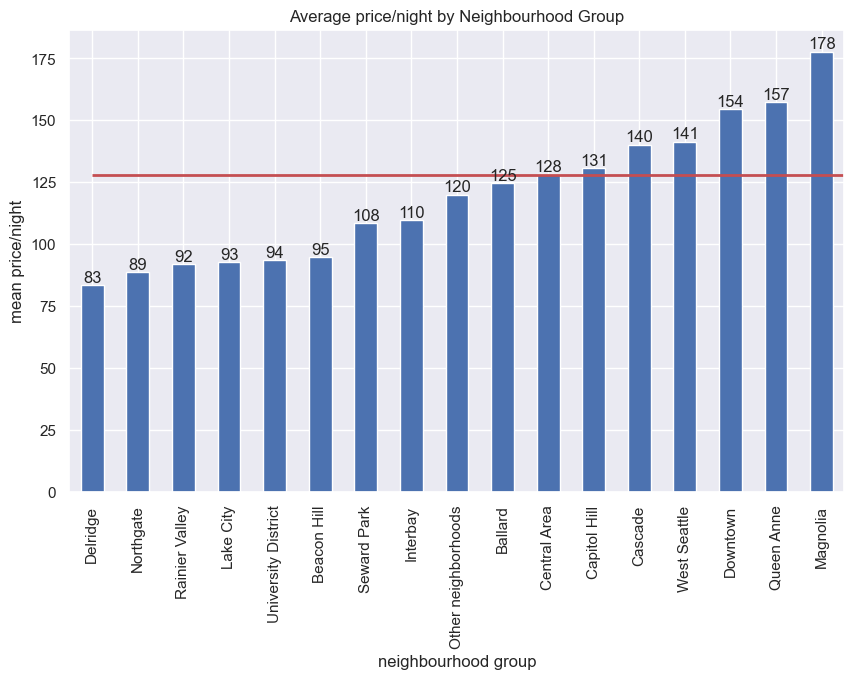

In [17]:
plot_graph_grouped_df(listings_df_clean, group_by='neighbourhood_group_cleansed', agg_col='price', agg_funct='mean', plot_kind='bar',
                      title='Average price/night by Neighbourhood Group', x_label='neighbourhood group', y_label='mean price/night')


Seattle's Airbnb listings have an average price per night of $128, but there are 6 neighbourhood areas with prices above this average. 
Magnolia area is at the top of the list with an average of $178 per night

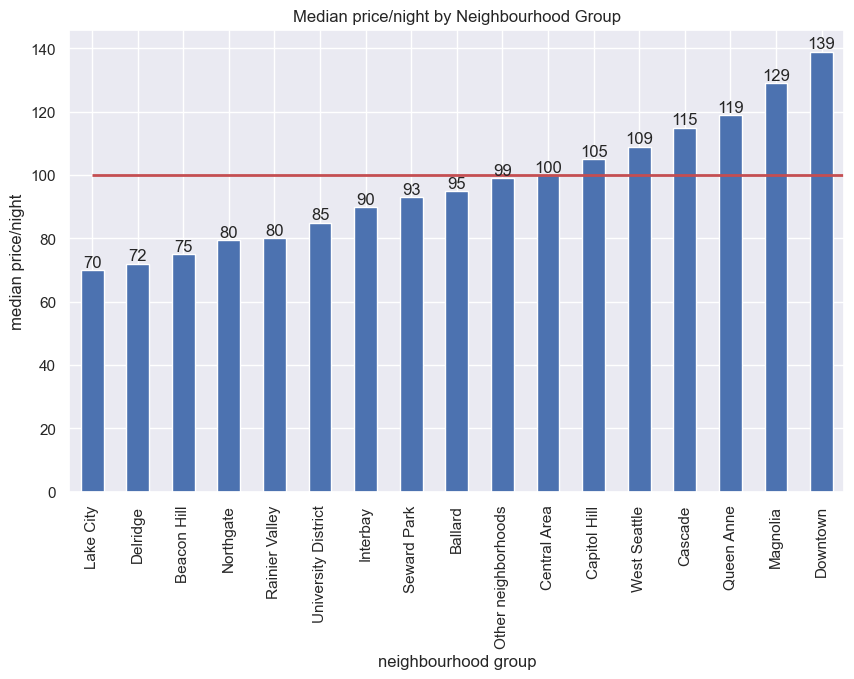

In [20]:
plot_graph_grouped_df(listings_df_clean, group_by='neighbourhood_group_cleansed', agg_col='price', agg_funct='median', plot_kind='bar',
                      title='Median price/night by Neighbourhood Group', x_label='neighbourhood group', y_label='median price/night')


Results show that Downtown Seattle comes out on top with the highest median price per night at $139. The fact that Magnolia has the highest average price but not the highest median price implies that there are some listings in Magnolia with exceptionally high prices, which have had an impact on the average price calculation.

#### Question 2

- What does the price trend look like throughout the year, and when is the most expensive time to visit the city?

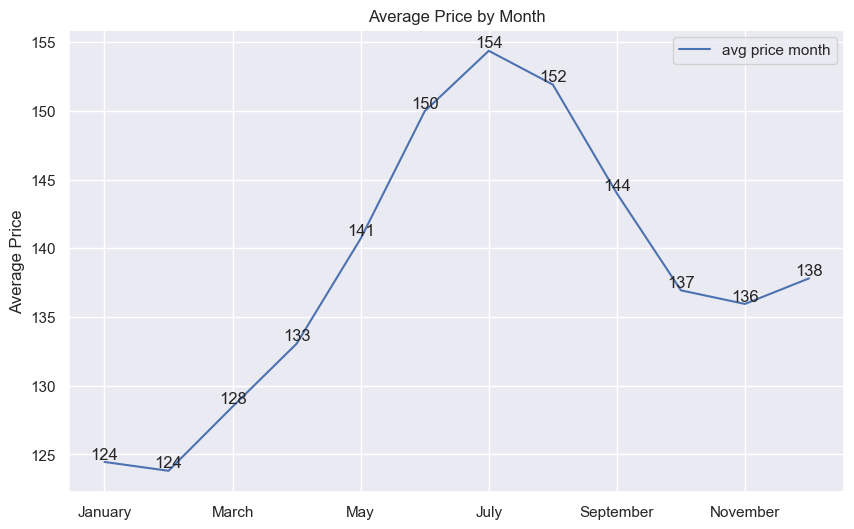

In [224]:
import calendar

# Group by month and month name
df_grouped = tr_calendar_df.groupby(['month', 'month_name'])[
    'avg price month'].mean()

# Sort by month and then drop month column
df_grouped = df_grouped.reset_index().sort_values(
    by='month').drop('month', axis=1)

# Plot the data
ax = df_grouped.plot(kind='line',
                     title='Average Price by Month',
                     x='month_name',
                     ylabel='Average Price',
                     xlabel='',
                     figsize=(10, 6))

# Add data labels to the chart
for i, v in enumerate(df_grouped['avg price month']):
    ax.annotate("{:.0f}".format(v), xy=(i, v), ha='center', va='bottom')

plt.show()


The price trend data throughout the year shows that there is a clear upward trend starting in March, reaching its peak during the summer months (June-August), and then gradually declining with a slight uptick in December, due to the Christmas and New years holidays.

July is the most expensive month to visit Seattle with an average price of $154 per night. This is around 25% more than the minimum average price seen in the colder months of January and February.

In [316]:
# Let's have a look at the listings with highest variance between avg price throught the year and the peak avg price month

calendar_df.groupby(['listing_id', 'avg price', 'max avg price month'])[
    'avg price month diff %'].mean().sort_values(ascending=False).head(20)


listing_id  avg price   max avg price month
6780615     169.008929  421.000000             149.099266
1416279     150.171875  373.500000             148.715014
4130112     213.905882  509.500000             138.188868
6975036     106.960784  200.000000              86.984418
6218849     41.819672   75.000000               79.341435
7074024     41.858974   75.000000               79.173047
7536219     98.011905   175.000000              78.549739
3312406     169.486804  298.870968              76.338784
5104918     187.851429  325.000000              73.009065
1476298     134.290541  228.225806              69.949280
4868135     235.972527  399.000000              69.087480
2191169     255.617284  431.318182              68.735922
6316917     137.425150  231.129032              68.185396
6592421     237.646884  399.000000              67.896163
8616606     156.302594  260.806452              66.859964
7735282     122.224299  203.870968              66.800685
1472532     140.654434  232.

Some listings may charge an additional 50% or more during peak season. As you can see in the example below, this listing is charging $399 in Jul/Aug, which is nearly 70% more than the average price of this listing, which is $235.

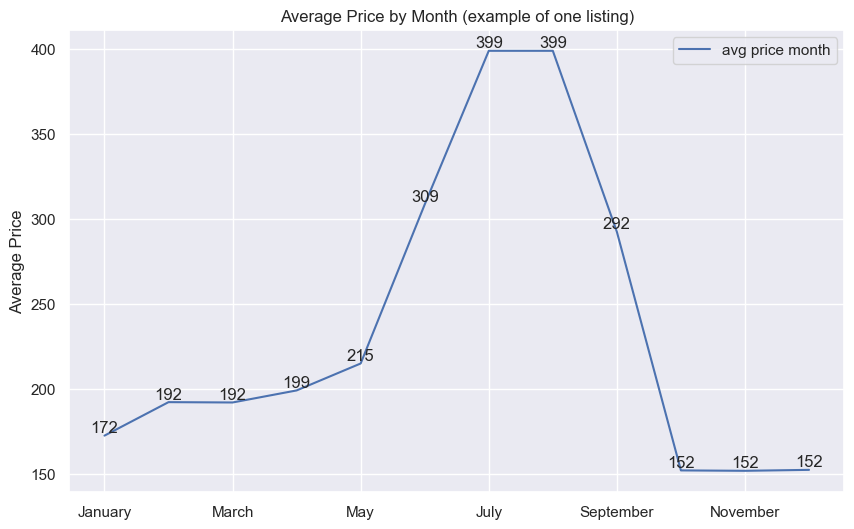

In [312]:
# Plot annual trend of a specific listing

listing_id = 4868135

# Group by month and month name
df_grouped = tr_calendar_df[tr_calendar_df['listing_id'] == listing_id].groupby(['month', 'month_name'])[
    'avg price month'].mean()

# Sort by month and then drop month column
df_grouped = df_grouped.reset_index().sort_values(
    by='month').drop('month', axis=1)

# Plot the data
ax = df_grouped.plot(kind='line',
                     title='Average Price by Month (example of one listing)',
                     x='month_name',
                     ylabel='Average Price',
                     xlabel='',
                     figsize=(10, 6))

# Add data labels to the chart
for i, v in enumerate(df_grouped['avg price month']):
    ax.annotate("{:.0f}".format(v), xy=(i, v), ha='center', va='bottom')

plt.show()


#### Question 3

- What type of properties are more likely to accept pets?

In [48]:
# Create column to identify whether listing accepts pets or not
listings_df_clean['pets_allowed'] = [
    "yes" if "Pets Allowed" in x else "no" for x in listings_df_clean['amenities']]

In [49]:
# Get number of listings where pets are allowed
listings_df_clean['pets_allowed'].value_counts()

no     3124
yes     435
Name: pets_allowed, dtype: int64

In [50]:
# For this analysis, we'll filter the listings to only include the main properties type: 'House', 'Apartment' and 'Townhouse'
selected_property_types = ['House', 'Apartment', 'Townhouse']
listings_df_clean = listings_df_clean[listings_df_clean['property_type'].isin(
    selected_property_types)]

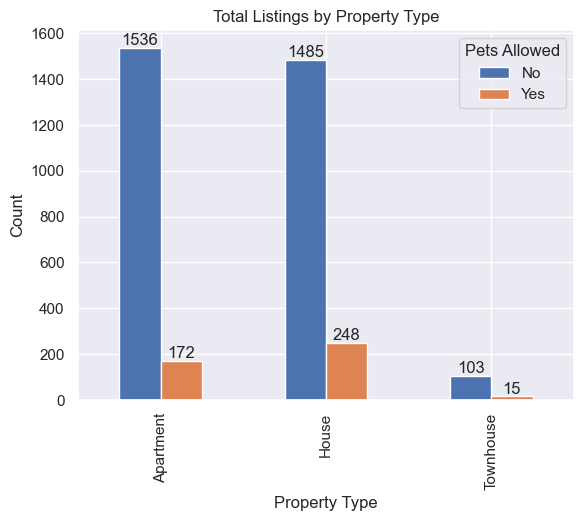

In [54]:
# Group the dataframe by property type and pets allowed, and count the number of listings
col_group_by = 'property_type'

grouped = listings_df_clean.groupby(
    [col_group_by, 'pets_allowed']).size().reset_index(name='count')

# Pivot the grouped dataframe to create a grouped bar chart
pivoted = grouped.pivot(index=col_group_by,
                        columns='pets_allowed', values='count')

# Create the bar chart
ax = pivoted.plot(kind='bar', stacked=False)

# Add labels and legend
ax.set_xlabel('Property Type')
ax.set_ylabel('Count')
ax.set_title('Total Listings by Property Type')
ax.legend(title='Pets Allowed', labels=['No', 'Yes'])

# Add labels to the bars
for p in ax.containers:
    ax.bar_label(p, label_type='edge')

# Show the chart
plt.show()

Results indicate a higher likelihood of finding a pet-friendly house compared to an apartment or townhouse

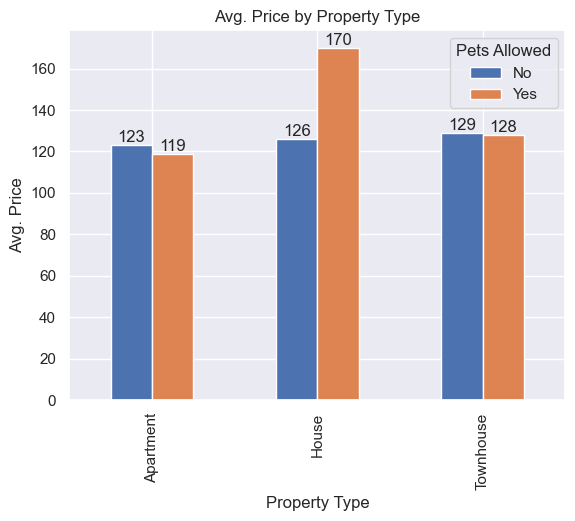

In [52]:
# Group the dataframe by property type and pets allowed, and get the mean avg price

col_group_by = 'property_type'

grouped = listings_df_clean.groupby(
    [col_group_by, 'pets_allowed'])['price'].mean().reset_index(name='mean')
grouped['mean'] = grouped['mean'].astype(int)

# Pivot the grouped dataframe to create a grouped bar chart
pivoted = grouped.pivot(index=col_group_by,
                        columns='pets_allowed', values='mean')

# Create the bar chart
ax = pivoted.plot(kind='bar', stacked=False)

# Add labels and legend
ax.set_xlabel('Property Type')
ax.set_ylabel('Avg. Price')
ax.set_title('Avg. Price by Property Type')
ax.legend(title='Pets Allowed', labels=['No', 'Yes'])

# Add labels to the bars
for p in ax.containers:
    ax.bar_label(p, label_type='edge')

# Show the chart
plt.show()

Average price for houses that allow pets is $44 higher compared to houses that are not pet friendly. On the other hand, there is no trend observed for apartments and townhouses.

<AxesSubplot:title={'center':'Pet-Friendly Listings by Neighborhood'}, ylabel='neighbourhood area'>

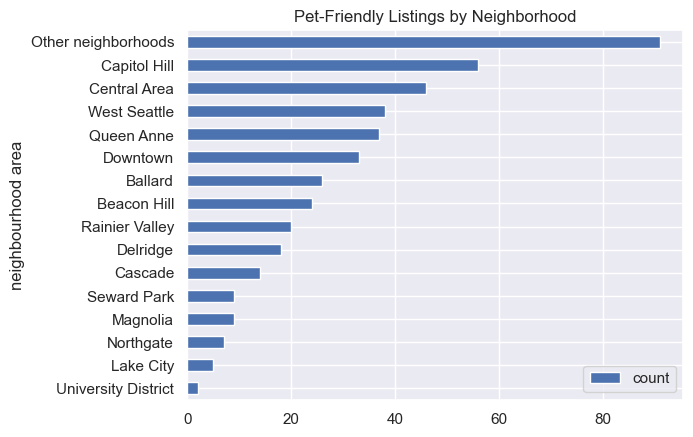

In [44]:
listings_df_pet_yes = listings_df_clean[listings_df_clean['pets_allowed'] == 'yes']
listings_df_pet_yes.groupby(['neighbourhood_group_cleansed']).size().reset_index(
    name='count').sort_values('count').plot(kind='barh', x='neighbourhood_group_cleansed', xlabel='neighbourhood area', title='Pet-Friendly Listings by Neighborhood')


<AxesSubplot:title={'center':'Pet-Friendly Listings in Other Neighborhoods'}, ylabel='neighbourhood area'>

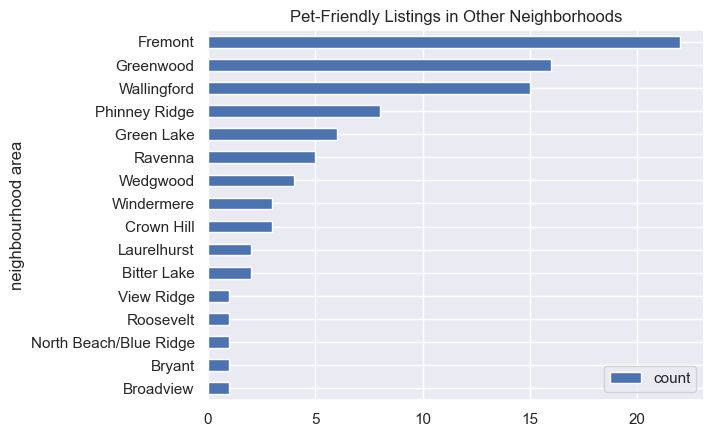

In [47]:
pet_yes_other_neighborhood = listings_df_pet_yes[listings_df_pet_yes[
    'neighbourhood_group_cleansed'] == 'Other neighborhoods']

pet_yes_other_neighborhood.groupby(['neighbourhood_cleansed']).size().reset_index(
    name='count').sort_values('count').plot(kind='barh', x='neighbourhood_cleansed', xlabel='neighbourhood area', title='Pet-Friendly Listings in Other Neighborhoods')


The areas of Capitol Hill, Central Area, and Other Neighborhoods have the highest number of pet-friendly Airbnb listings. Specifically, within the Other Neighborhoods group, Fremont, Greenwood, and Wallingford offer the largest selection of properties that welcome pets.